<h1><center>Dependencies Installation</center></h1>

In [485]:
import random
%pip install pandas==2.2.2
%pip install matplotlib==3.9.2
%pip install seaborn==0.13.2
%pip install scikit-learn==1.5.2
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


<h1><center>Import all needed libraries</center></h1>

In [486]:
import os
import itertools
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Subset, DataLoader

from scipy.stats import ttest_rel
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

<h1><center>Setup agnostic device</center></h1

In [487]:
device_name = (
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)

device = torch.device(device_name)
print(f'Using {device_name} device')

Using cuda device


<h1><center>Data Preparation</center></h1>

<h2>Read in dataset</h2>

In [488]:
ROOT_DIR: str = Path().resolve().parent
DATA_DIR: str = os.path.join(ROOT_DIR, 'data')
INTERIM_DIR: str = os.path.join(DATA_DIR, 'interim')
OUTPUT_DIR: str = os.path.join(DATA_DIR, 'output')

df: pd.DataFrame = pd.read_csv(f'{INTERIM_DIR}/almond.csv').drop(columns=['Unnamed: 0'])
df

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA
1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,NaN,0.656353,24065.5,MAMRA
2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,NaN,0.683620,23144.0,MAMRA
3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,NaN,0.685360,23385.0,MAMRA
4,NaN,230.150742,107.253448,19068.0,624.842706,NaN,0.951450,1.629395,NaN,NaN,0.714800,20041.0,MAMRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,NaN,192.709366,122.356506,18471.5,653.345233,NaN,0.931000,1.838965,NaN,NaN,0.725739,19840.5,SANORA
2799,NaN,186.254745,118.708961,17213.5,581.688379,NaN,0.952706,1.564234,NaN,NaN,0.714016,18068.0,SANORA
2800,NaN,186.196182,119.147224,17510.5,608.315795,NaN,0.948821,1.681705,NaN,NaN,0.718999,18455.0,SANORA
2801,NaN,188.660828,120.634438,17941.0,630.759446,NaN,0.944810,1.764701,NaN,NaN,0.738191,18989.0,SANORA


In [489]:
df.head()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA
1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,NaN,0.656353,24065.5,MAMRA
2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,NaN,0.683620,23144.0,MAMRA
3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,NaN,0.685360,23385.0,MAMRA
4,NaN,230.150742,107.253448,19068.0,624.842706,NaN,0.951450,1.629395,NaN,NaN,0.714800,20041.0,MAMRA


In [490]:
df.tail()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
2798,NaN,192.709366,122.356506,18471.5,653.345233,NaN,0.931000,1.838965,NaN,NaN,0.725739,19840.5,SANORA
2799,NaN,186.254745,118.708961,17213.5,581.688379,NaN,0.952706,1.564234,NaN,NaN,0.714016,18068.0,SANORA
2800,NaN,186.196182,119.147224,17510.5,608.315795,NaN,0.948821,1.681705,NaN,NaN,0.718999,18455.0,SANORA
2801,NaN,188.660828,120.634438,17941.0,630.759446,NaN,0.944810,1.764701,NaN,NaN,0.738191,18989.0,SANORA
2802,269.356903,176.023636,NaN,36683.5,887.310743,0.643761,0.947380,1.707933,1.530231,0.75693,0.722429,38721.0,SANORA


In [491]:
df.columns

Index(['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)',
       'Area', 'Perimeter', 'Roundness', 'Solidity', 'Compactness',
       'Aspect Ratio', 'Eccentricity', 'Extent', 'Convex hull(convex area)',
       'Type'],
      dtype='object')

<h2>Sanity-check on the dataset</h2>

<h3><li>Find and drop duplicates across rows</li></h3>

In [492]:
df.duplicated().sum()

np.int64(3)

In [493]:
df.drop_duplicates(inplace=True)

In [494]:
df.duplicated().sum()

np.int64(0)

<h3><li>Check the shape of the dataset and see if there are any null values in columns</li></h3>

In [495]:
df.shape

(2800, 13)

In [496]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2800 entries, 0 to 2802
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Length (major axis)       1944 non-null   float64
 1   Width (minor axis)        1859 non-null   float64
 2   Thickness (depth)         1797 non-null   float64
 3   Area                      2800 non-null   float64
 4   Perimeter                 2800 non-null   float64
 5   Roundness                 1944 non-null   float64
 6   Solidity                  2800 non-null   float64
 7   Compactness               2800 non-null   float64
 8   Aspect Ratio              1003 non-null   float64
 9   Eccentricity              1003 non-null   float64
 10  Extent                    2800 non-null   float64
 11  Convex hull(convex area)  2800 non-null   float64
 12  Type                      2800 non-null   object 
dtypes: float64(12), object(1)
memory usage: 306.2+ KB


In [497]:
df.isna().sum()

Length (major axis)          856
Width (minor axis)           941
Thickness (depth)           1003
Area                           0
Perimeter                      0
Roundness                    856
Solidity                       0
Compactness                    0
Aspect Ratio                1797
Eccentricity                1797
Extent                         0
Convex hull(convex area)       0
Type                           0
dtype: int64

In [498]:
(df.isnull().sum() / df.shape[0]) * 100

Length (major axis)         30.571429
Width (minor axis)          33.607143
Thickness (depth)           35.821429
Area                         0.000000
Perimeter                    0.000000
Roundness                   30.571429
Solidity                     0.000000
Compactness                  0.000000
Aspect Ratio                64.178571
Eccentricity                64.178571
Extent                       0.000000
Convex hull(convex area)     0.000000
Type                         0.000000
dtype: float64

<h3><li>Visualize the distribution of the data</li></h3>

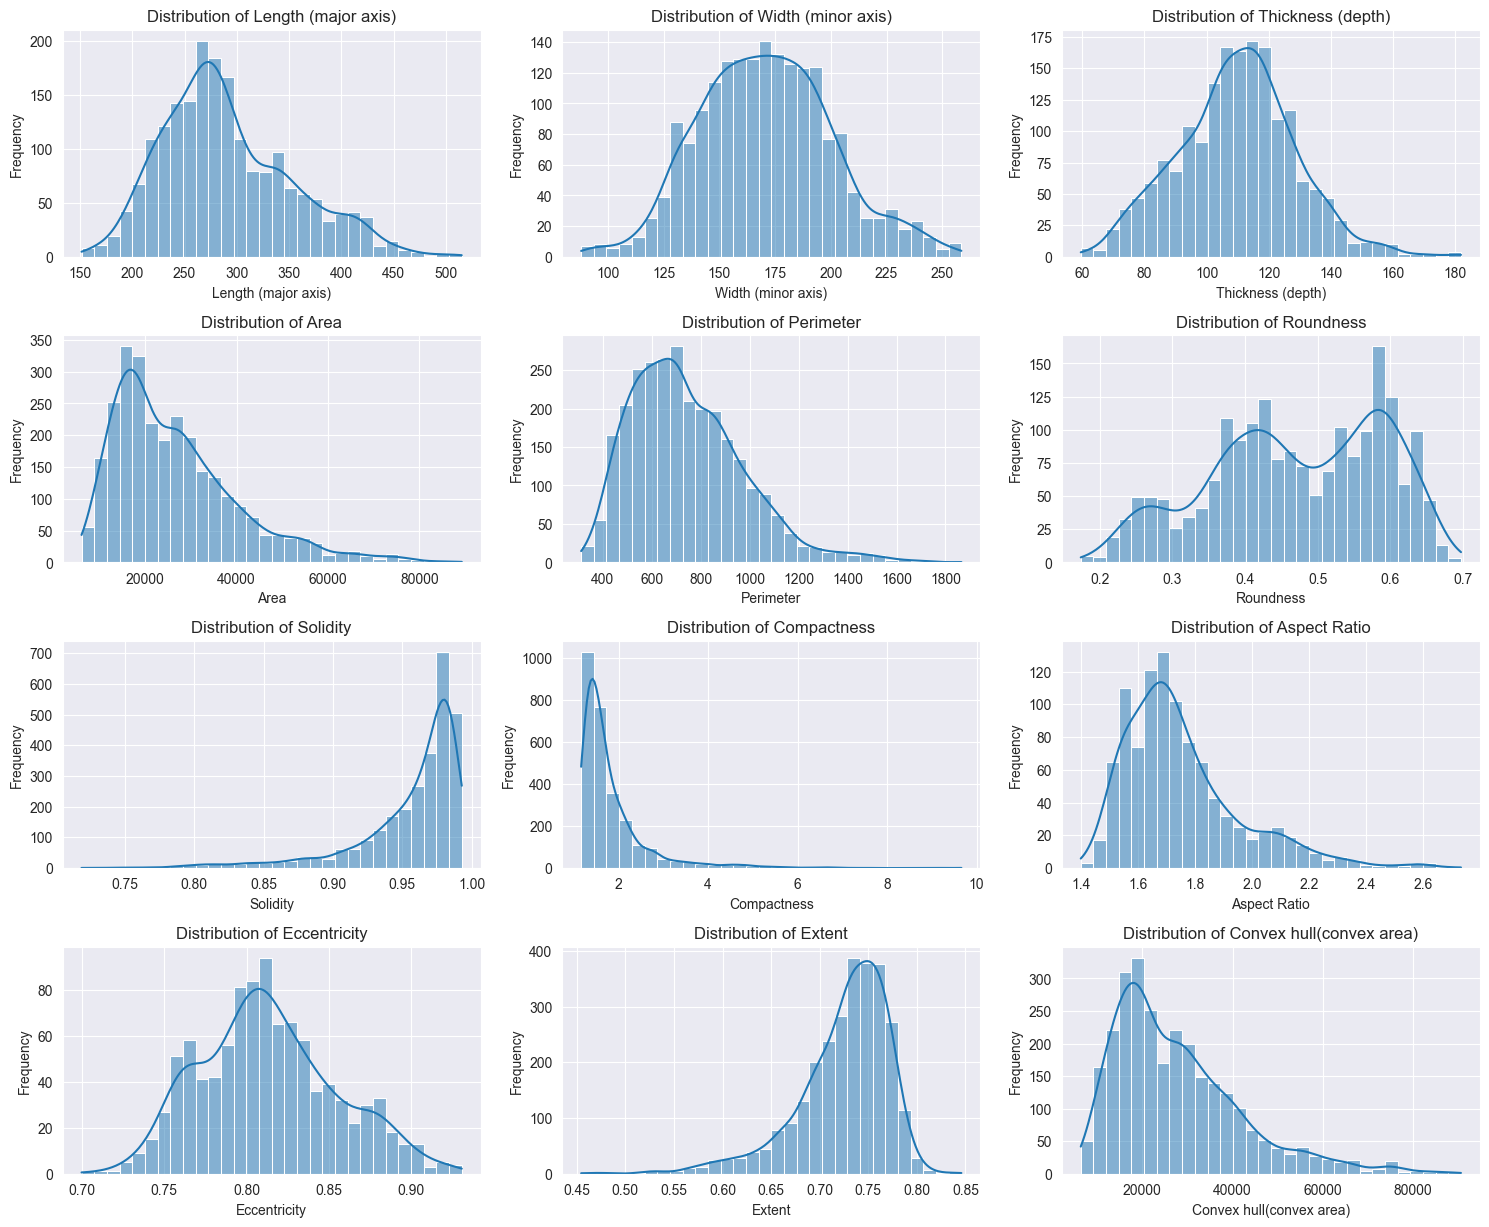

In [499]:
numeric_columns = df.columns

plt.figure(figsize=(15, 15))
for i, column in enumerate(numeric_columns, 1):
    if column == 'Type':
        continue
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<h3><li>Log transform the columns with outliers</li></h3>

In [500]:
for column_name in numeric_columns:
    if column_name != 'Type' and not (-0.5 < df[column_name].skew() < 0.5):
        print(column_name)
        df[column_name] = np.log(df[column_name])

Length (major axis)
Area
Perimeter
Solidity
Compactness
Aspect Ratio
Extent
Convex hull(convex area)


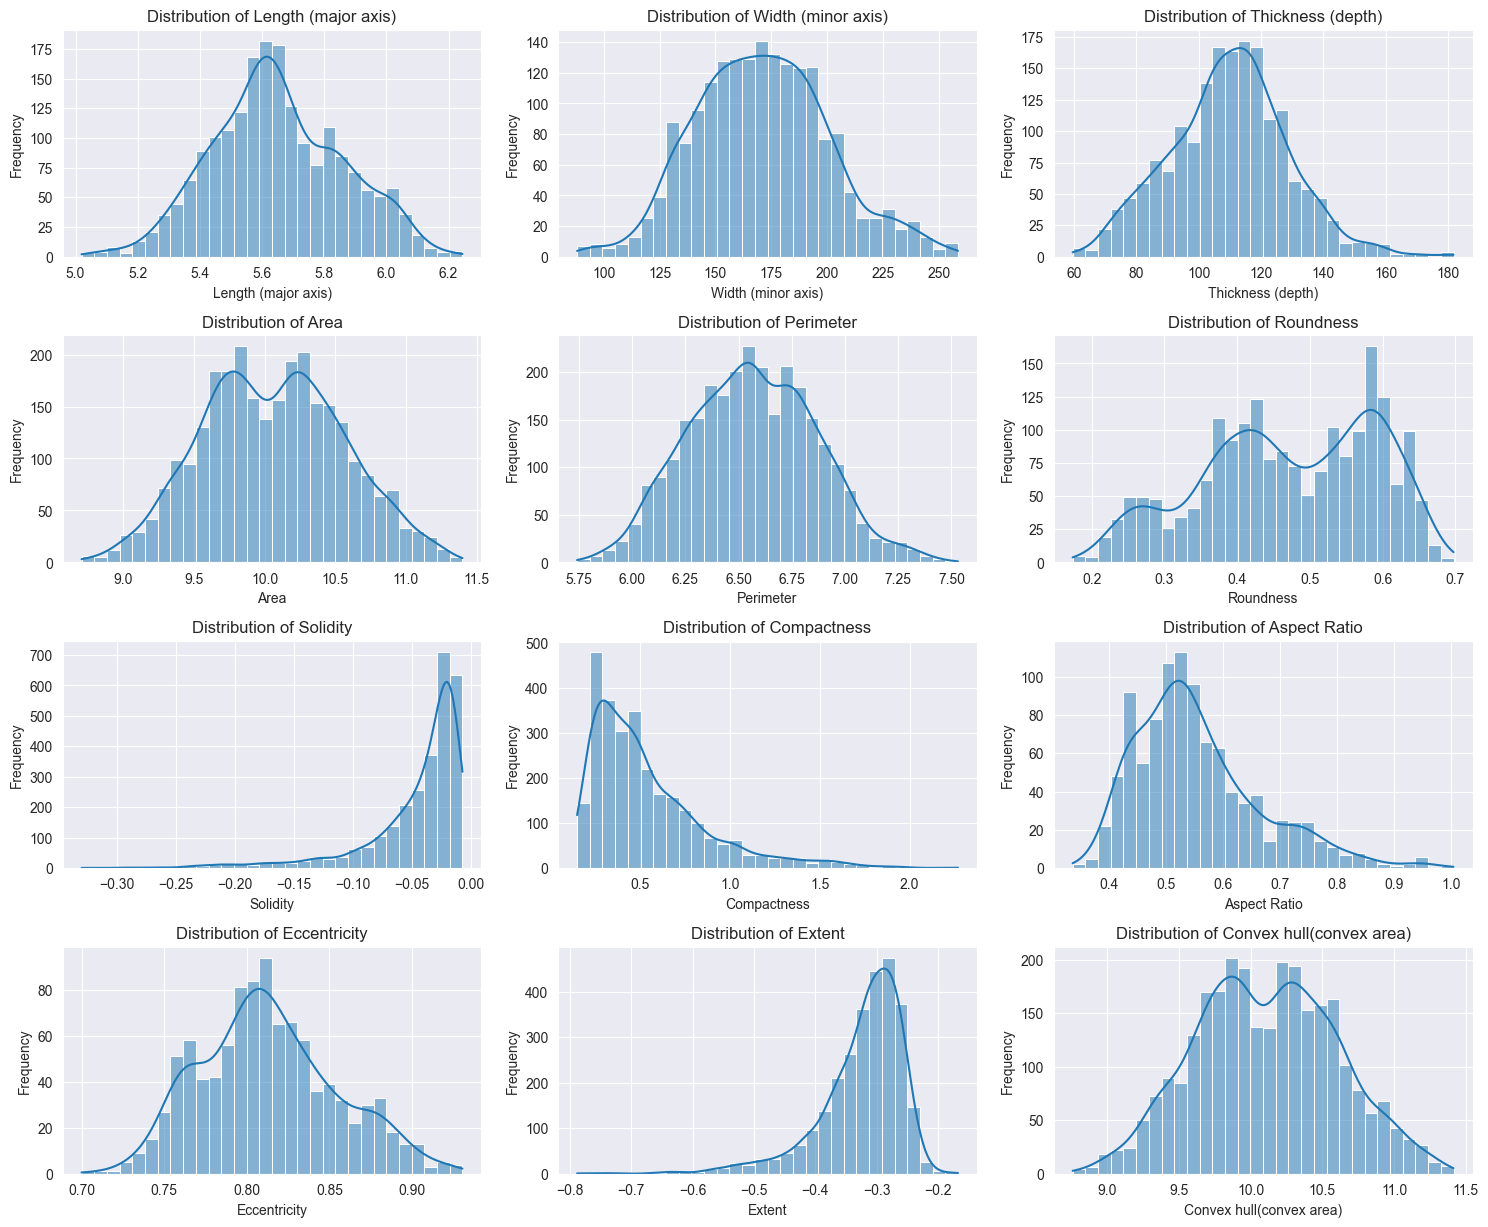

In [501]:
numeric_columns = df.columns

plt.figure(figsize=(15, 15))
for i, column in enumerate(numeric_columns, 1):
    if column == 'Type':
        continue
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<h3><li>Fill in the missing null values</li></h3>

In [502]:
columns_with_missing_values: List[str] = df.columns[df.isnull().any()].tolist()
knn_imputer: KNNImputer = KNNImputer(n_neighbors=5)
df[columns_with_missing_values] = knn_imputer.fit_transform(df[columns_with_missing_values])
df.isnull().sum()

Length (major axis)         0
Width (minor axis)          0
Thickness (depth)           0
Area                        0
Perimeter                   0
Roundness                   0
Solidity                    0
Compactness                 0
Aspect Ratio                0
Eccentricity                0
Extent                      0
Convex hull(convex area)    0
Type                        0
dtype: int64

<h3><li>Find garbage values in the target variable 'Type'</li></h3>

In [503]:
column_name: str = 'Type'
print('****' * 5 + ' START ' + '****' * 5)
print(df[column_name].value_counts())
print('****' * 5 + ' END ' + '****' * 6)

******************** START ********************
Type
SANORA     943
MAMRA      931
REGULAR    926
Name: count, dtype: int64
******************** END ************************


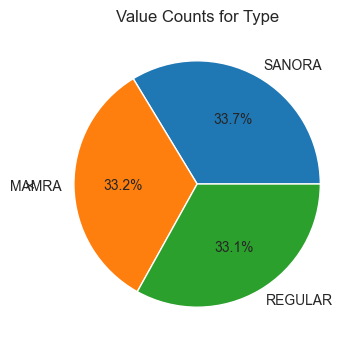

In [504]:
plt.figure(figsize=(8, 4))
df[column_name].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title(f'Value Counts for {column_name}')
plt.ylabel('x')
plt.show()

<h3><li>Encode the Target Variable</li></h3>

In [505]:
label_encoder: LabelEncoder = LabelEncoder()
df['Type'] = label_encoder.fit_transform(df['Type'])
df.head(10)

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,5.673988,227.940628,127.759132,10.026546,6.467409,0.435261,-0.026977,0.377248,0.544943,0.813676,-0.383910,10.053523,0
1,5.773174,234.188126,128.199509,10.044900,6.523540,0.386345,-0.043634,0.471156,0.596331,0.834103,-0.421056,10.088535,0
2,5.893441,229.418610,125.796547,10.016213,6.472259,0.373263,-0.033277,0.397279,0.621247,0.843012,-0.380353,10.049491,0
3,5.901122,232.763153,125.918808,10.024753,6.494098,0.323533,-0.035097,0.432418,0.618400,0.842008,-0.377811,10.059850,0
4,5.750088,230.150742,107.253448,9.855767,6.437500,0.341276,-0.049769,0.488209,0.621247,0.843012,-0.335753,9.905535,0
5,5.625785,231.914429,107.759789,9.869672,6.422251,0.384697,-0.043592,0.443806,0.624126,0.844081,-0.317565,9.913265,0
6,5.778433,226.371048,106.479408,9.830029,6.419950,0.376608,-0.044699,0.478847,0.547415,0.812972,-0.317580,9.874728,0
7,5.597912,226.186142,102.623077,9.801981,6.371372,0.374940,-0.031513,0.409740,0.547415,0.812972,-0.300194,9.833494,0
8,6.024602,161.468430,138.190536,10.633256,6.983776,0.309009,-0.050256,0.803272,0.895044,0.912409,-0.264427,10.683512,0
9,6.035984,176.876733,129.659897,10.612274,6.946426,0.295783,-0.045114,0.749554,0.907834,0.914750,-0.276284,10.657389,0


<h3><li>Display heatmap of correlation matrix</li></h3>

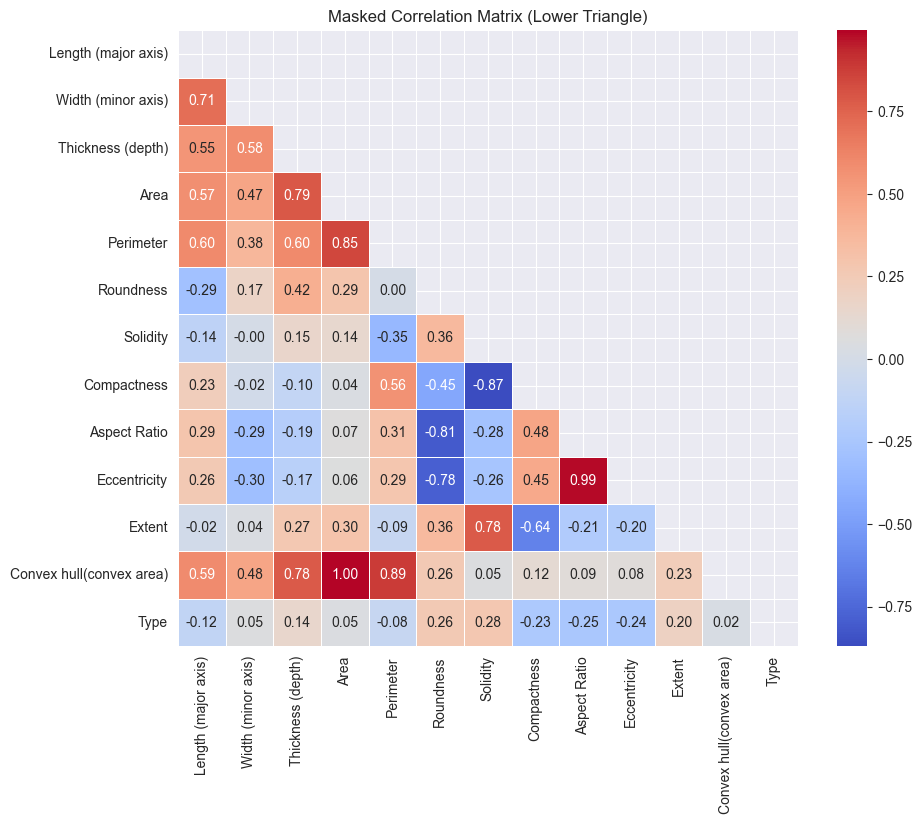

In [506]:
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Masked Correlation Matrix (Lower Triangle)')

PREPROCESSING_DIR: str = os.path.join(OUTPUT_DIR, 'preprocessing')
plt.savefig(f'{PREPROCESSING_DIR}/masked_correlation_matrix.png')
plt.show()

<h3><li>Drop highly correlated features</li></h3>

In [507]:
correlation_matrix = correlation_matrix.abs()

threshold = 0.9
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
df.drop(columns=to_drop, inplace=True)

<h2>Exploratory Data Analysis (EDA)</h2>

<h3><li>Perform statistical analysis on the dataset</li></h3>

In [508]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Length (major axis),2800.0,5.655989,0.190412,5.019498,5.538745,5.649645,5.775380,6.244851
Width (minor axis),2800.0,161.299771,30.887263,88.050529,140.639366,158.792329,181.031261,258.569794
Thickness (depth),2800.0,117.033234,20.147525,59.494278,104.361006,117.119347,131.933393,181.845200
Area,2800.0,10.060986,0.497880,8.705662,9.693630,10.061388,10.417747,11.399555
Perimeter,2800.0,6.565923,0.300712,5.741603,6.348356,6.561235,6.778586,7.530988
Roundness,2800.0,0.464767,0.104252,0.173748,0.394901,0.460754,0.546314,0.697293
Solidity,2800.0,-0.045986,0.043236,-0.330210,-0.056853,-0.029962,-0.018683,-0.007136
Compactness,2800.0,0.539835,0.318676,0.152265,0.305542,0.455128,0.674971,2.268000
Aspect Ratio,2800.0,0.629324,0.136269,0.336531,0.520414,0.593363,0.754952,1.004760
Extent,2800.0,-0.324343,0.069056,-0.788474,-0.353981,-0.309548,-0.277608,-0.167458


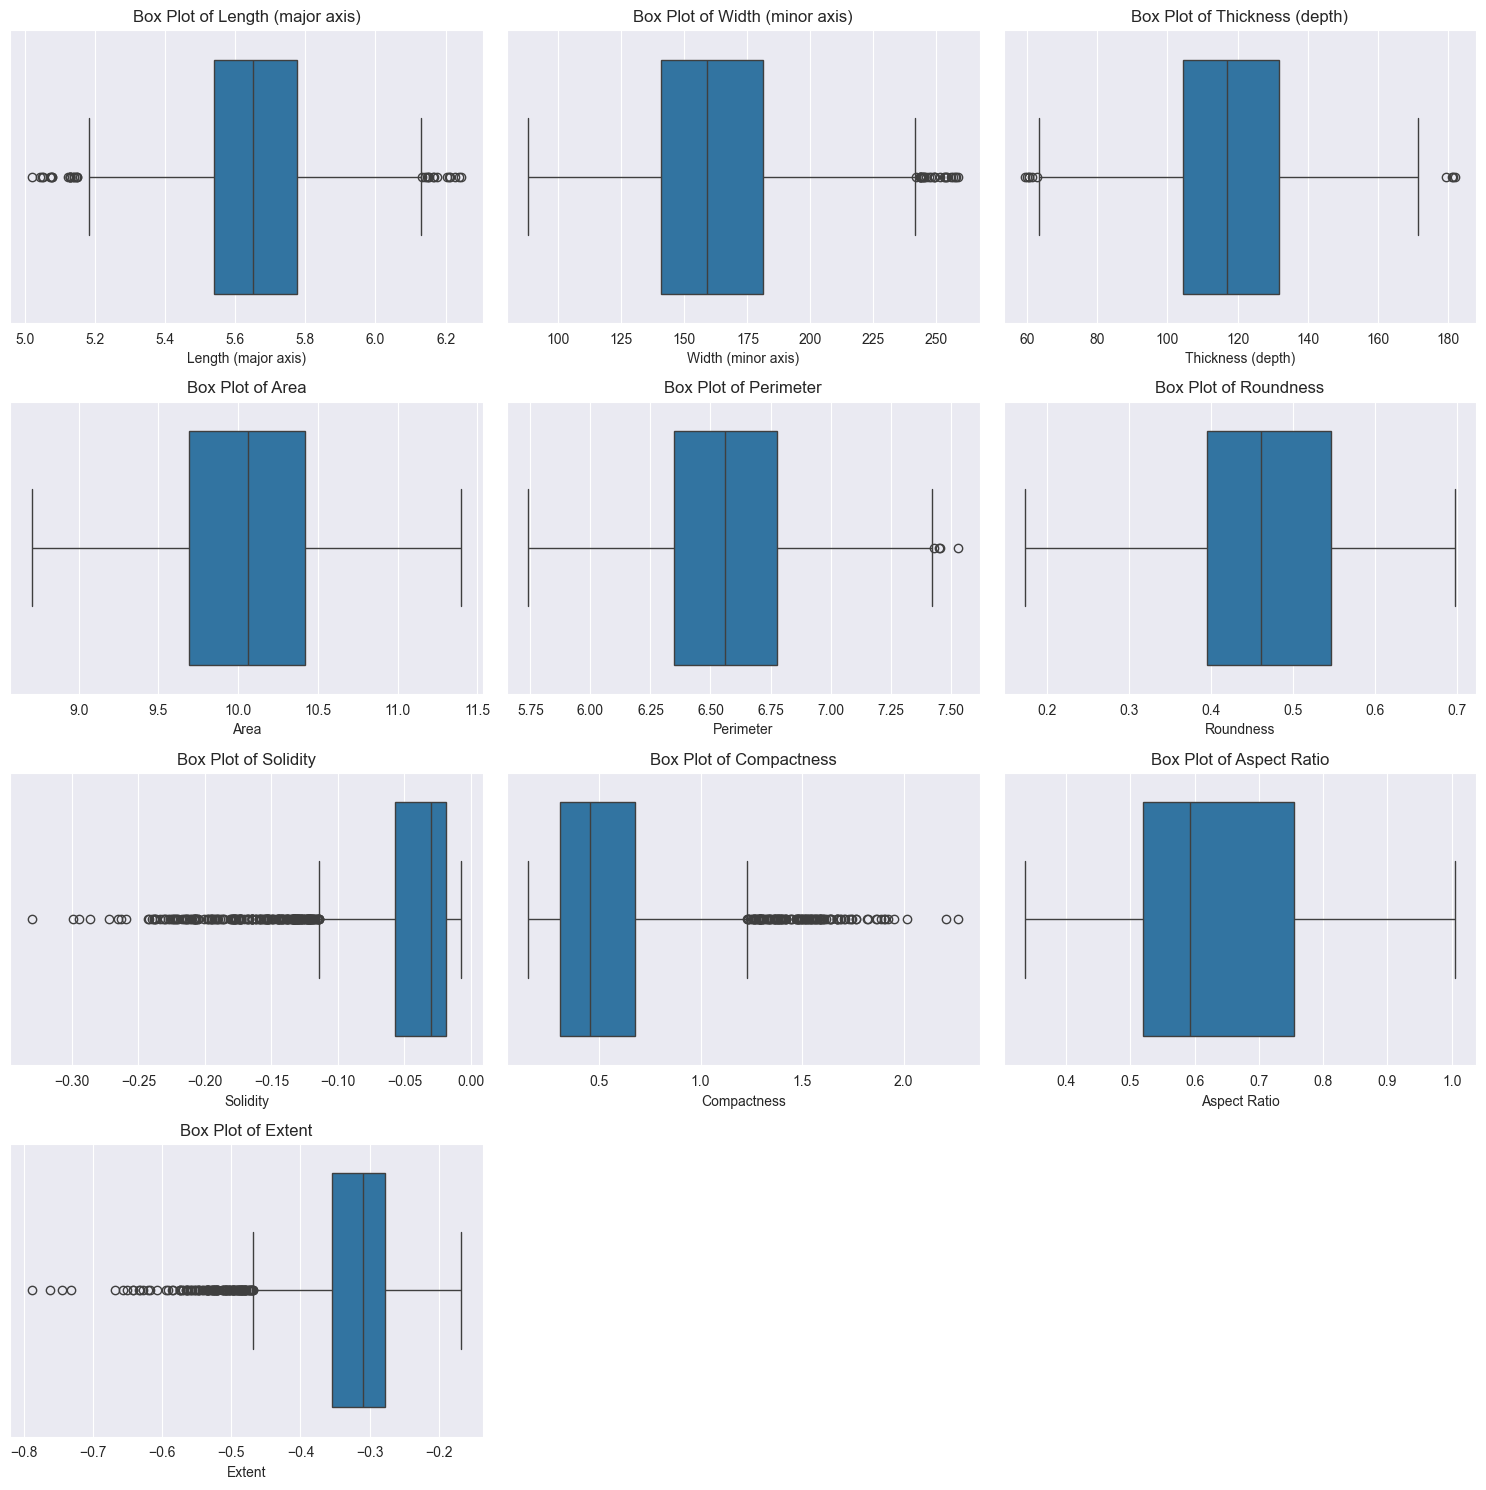

In [509]:
numeric_columns = df.columns

plt.figure(figsize=(15, 15))
for i, column in enumerate(numeric_columns, 1):
    if column == 'Type':
        continue
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

<h3><li>Standardize the features data</li></h3>

In [510]:
scaler = StandardScaler()

columns_to_scale: List[str] = df.columns.tolist()
columns_to_scale.remove('Type')

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df.head()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Extent,Type
0,0.094539,2.157937,0.532463,-0.069187,-0.327661,-0.283077,0.439736,-0.510288,-0.619342,-0.862755,0
1,0.615538,2.360241,0.554325,-0.032314,-0.140966,-0.752375,0.054407,-0.215554,-0.242161,-1.400762,0
2,1.247260,2.205796,0.435035,-0.089943,-0.311530,-0.877875,0.293990,-0.447417,-0.059289,-0.811237,0
3,1.287607,2.314098,0.441104,-0.072787,-0.238892,-1.354977,0.251907,-0.337133,-0.080180,-0.774417,0
4,0.494272,2.229504,-0.485495,-0.412260,-0.427138,-1.184752,-0.087499,-0.162032,-0.059289,-0.165260,0


<h2>Turn data into tensors and split the data into train and test datasets</h2>

In [511]:
X = df.drop('Type', axis=1)
y = df['Type']

num_of_features = X.shape[1]
num_of_classes = y.nunique()
num_of_features, num_of_classes

(10, 3)

In [512]:
X_tensor = torch.tensor(X.values, dtype=torch.float)
y_tensor = torch.tensor(y.values, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)

<h1><center>Implementation</center></h1>

<h2>Setup NeuralNetwork</h2>


In [513]:
class AlmondClassificationNN(nn.Module):
    def __init__(
            self,
            seed: int,
            in_features: int,
            out_features: int,
            hidden_layers=None
    ):
        super(AlmondClassificationNN, self).__init__()
        self.seed = seed
        self._seed_model()

        if hidden_layers is None:
            hidden_layers = [(10, 10)]

        self.input = nn.Linear(in_features, hidden_layers[0][0])
        self.input_activation = nn.ReLU()

        self.hidden_layers = nn.ModuleList()
        self.num_of_hidden_layers = len(hidden_layers)
        for index in range(0, self.num_of_hidden_layers):
            in_neurons, out_neurons = hidden_layers[index]
            self.hidden_layers.append(nn.Linear(in_neurons, out_neurons))
            self.hidden_layers.append(nn.ReLU())

        self.output = nn.Linear(hidden_layers[-1][1], out_features)
        self.output_activation = F.softmax

        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def _seed_model(self):
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)

        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

    def forward(self, features):
        features = self.input_activation(self.input(features))

        for hidden_layer in self.hidden_layers:
            features = hidden_layer(features)

        return self.output(features)

<h2>Setup neural network and training algorithms / optimizers</h2>

In [514]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

RESULTS_DIR: str = os.path.join(OUTPUT_DIR, 'results')


def grid_search(
        seed: int,
        num_of_splits: int,
        param_grid: dict,
        num_of_epoches: int,
        optimizer_name: str,
        optimizer_momentum: float,
):
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # Collect results for each hyperparameter combination
    all_results = {}
    best_combination = None
    best_accuracy = 0.0
    best_std = None

    results_data = []

    for param_combination in param_combinations:
        learning_rate = param_combination['learning_rate']
        hidden_layers = tuple(param_combination['hidden_layers'])  # Convert hidden_layers list to tuple

        kf = KFold(n_splits=num_of_splits, shuffle=True, random_state=seed)

        fold_accuracies = []
        fold_losses = []

        for fold, (train_index, validation_index) in enumerate(kf.split(dataset)):
            train_subset = Subset(dataset, train_index)
            validation_subset = Subset(dataset, validation_index)

            train_loader = DataLoader(train_subset, batch_size=12, shuffle=True)
            validation_loader = DataLoader(validation_subset, batch_size=12)

            neuralnetwork = AlmondClassificationNN(
                seed=seed,
                in_features=num_of_features,
                out_features=num_of_classes,
                hidden_layers=hidden_layers,
            ).to(device=device)

            criterion = nn.CrossEntropyLoss()

            optimizers_dict = {
                'sgd': optim.SGD(neuralnetwork.parameters(), lr=learning_rate, momentum=optimizer_momentum),
                'adam': optim.Adam(neuralnetwork.parameters(), lr=learning_rate),
                'rmsprop': optim.RMSprop(neuralnetwork.parameters(), lr=learning_rate),
                'rprop': optim.Rprop(neuralnetwork.parameters(), lr=learning_rate)
            }
            optimizer = optimizers_dict.get(optimizer_name)

            for epoch in range(num_of_epoches):
                neuralnetwork.train()

                for X_train_batch, y_train_batch in train_loader:
                    X_train_batch = X_train_batch.to(device=device)
                    y_train_batch = y_train_batch.to(device=device)
                    
                    optimizer.zero_grad()
                    y_batch_prediction = neuralnetwork(X_train_batch)
                    loss = criterion(y_batch_prediction, y_train_batch.long())
                    loss.backward()
                    optimizer.step()

            with torch.no_grad():
                neuralnetwork.eval()

                validation_predictions = []
                validation_true = []
                running_validation_loss = 0.0

                for X_validation_batch, y_validation_batch in validation_loader:
                    X_validation_batch = X_validation_batch.to(device=device)
                    y_validation_batch = y_validation_batch.to(device=device)
                    
                    y_validation_prediction = neuralnetwork(X_validation_batch)
                    loss = criterion(y_validation_prediction, y_validation_batch.long())
                    running_validation_loss += loss.item()

                    _, predicted = torch.max(y_validation_prediction, 1)
                    validation_predictions.extend(predicted.cpu().numpy())
                    validation_true.extend(y_validation_batch.cpu().numpy())

                accuracy = accuracy_score(validation_true, validation_predictions)
                fold_accuracies.append(accuracy)
                fold_losses.append(running_validation_loss / len(validation_loader))

        mean_accuracy = np.mean(fold_accuracies)
        mean_loss = np.mean(fold_losses)
        std_accuracy = np.std(fold_accuracies)

        param_key = str({'learning_rate': learning_rate, 'hidden_layers': hidden_layers})
        all_results[param_key] = {
            'accuracies': fold_accuracies,
            'losses': fold_losses
        }

        results_data.append({
            'learning_rate': learning_rate,
            'hidden_layers': hidden_layers,
            'mean_accuracy': mean_accuracy,
            'mean_loss': mean_loss,
            'std_accuracy': std_accuracy,
            't_stat_acc': None,
            'p_value_acc': None,
            't_stat_loss': None,
            'p_value_loss': None
        })

    print('Hypothesis Testing for Parameter Combinations:')

    for first_combination_index, first_combination in enumerate(results_data):
        for second_combination_index, second_combination in enumerate(results_data):
            if first_combination_index >= second_combination_index:
                continue

            first_combination_key = str({
                'learning_rate': first_combination['learning_rate'],
                'hidden_layers': first_combination['hidden_layers']
            })
            second_combination_key = str({
                'learning_rate': second_combination['learning_rate'],
                'hidden_layers': second_combination['hidden_layers']
            })

            first_accuracy = all_results[first_combination_key]['accuracies']
            second_accuracy = all_results[second_combination_key]['accuracies']
            first_loss = all_results[first_combination_key]['losses']
            second_loss = all_results[second_combination_key]['losses']

            t_stat_accuracy, p_value_accuracy = ttest_rel(first_accuracy, second_accuracy)
            t_stat_loss, p_value_loss = ttest_rel(first_loss, second_loss)

            results_data[first_combination_index]['t_stat_acc'] = t_stat_accuracy
            results_data[first_combination_index]['p_value_acc'] = p_value_accuracy
            results_data[first_combination_index]['t_stat_loss'] = t_stat_loss
            results_data[first_combination_index]['p_value_loss'] = p_value_loss

    results_df = pd.DataFrame(results_data)
    results_df['rank'] = results_df[['mean_accuracy', 'mean_loss']].apply(
        lambda x: (x['mean_accuracy'], -x['mean_loss']), axis=1
    ).rank(method='min', ascending=False)

    results_df = results_df.sort_values(by=['mean_accuracy', 'mean_loss'], ascending=[False, True])

    optimizer_directory = os.path.join(RESULTS_DIR, optimizer_name)
    os.makedirs(optimizer_directory, exist_ok=True)
    
    random_number = random.randint(0, 1000)

    optimizer_results_filename = os.path.join(optimizer_directory, f'{optimizer_name}_hypothesis_testing_results_{random_number}.csv')
    results_df.to_csv(optimizer_results_filename, index=False)
    print(
        f'Results ranked by max accuracy and min loss, including t-tests and p-values, saved to {optimizer_results_filename}'
    )

    best_combination = results_df.iloc[0][['learning_rate', 'hidden_layers']].to_dict()
    print(f'Best Hyperparameter Combination Based on Ranking: {best_combination}')

    heatmap_data_accuracy = pd.pivot_table(results_df, values='mean_accuracy', index='hidden_layers',
                                           columns='learning_rate')
    heatmap_data_loss = pd.pivot_table(results_df, values='mean_loss', index='hidden_layers', columns='learning_rate')

    plt.figure(figsize=(20, 12))
    sns.heatmap(heatmap_data_accuracy, annot=True, cmap='Blues')
    plt.title(f'{optimizer_name.upper()} - Mean Accuracy Heatmap', pad=20)
    plt.ylabel('Hidden Layers', labelpad=20)
    plt.xlabel('Learning Rate', labelpad=20)
    accuracy_heatmap_path = os.path.join(optimizer_directory, f'{optimizer_name}_accuracy_heatmap_{random_number}.png')
    plt.savefig(accuracy_heatmap_path)
    plt.plot()

    plt.figure(figsize=(20, 12))
    sns.heatmap(heatmap_data_loss, annot=True, cmap='Blues')
    plt.title(f'{optimizer_name.upper()} - Mean Loss Heatmap', pad=20)
    plt.ylabel('Hidden Layers', labelpad=20)
    plt.xlabel('Learning Rate', labelpad=20)
    loss_heatmap_path = os.path.join(optimizer_directory, f'{optimizer_name}_loss_heatmap_{random_number}.png')
    plt.savefig(loss_heatmap_path)
    plt.plot()

    print(f'Accuracy and Loss heatmaps saved to {accuracy_heatmap_path} and {loss_heatmap_path}')


=========PERFORMING GRID SEARCH FOR OPTIMIZER RPROP=========
Hypothesis Testing for Parameter Combinations:
Results ranked by max accuracy and min loss, including t-tests and p-values, saved to C:\Users\ished\Desktop\TUKS\COS 711 - Artificial Intelligence (II)\Assignments\02\hybrid-learning-in-neural-networks-for-almond-classification\data\output\results\rprop\rprop_hypothesis_testing_results_387.csv
Best Hyperparameter Combination Based on Ranking: {'learning_rate': 0.003, 'hidden_layers': ((512, 256), (256, 128), (128, 64), (64, 32), (32, 16))}
Accuracy and Loss heatmaps saved to C:\Users\ished\Desktop\TUKS\COS 711 - Artificial Intelligence (II)\Assignments\02\hybrid-learning-in-neural-networks-for-almond-classification\data\output\results\rprop\rprop_accuracy_heatmap_387.png and C:\Users\ished\Desktop\TUKS\COS 711 - Artificial Intelligence (II)\Assignments\02\hybrid-learning-in-neural-networks-for-almond-classification\data\output\results\rprop\rprop_loss_heatmap_387.png

=========P

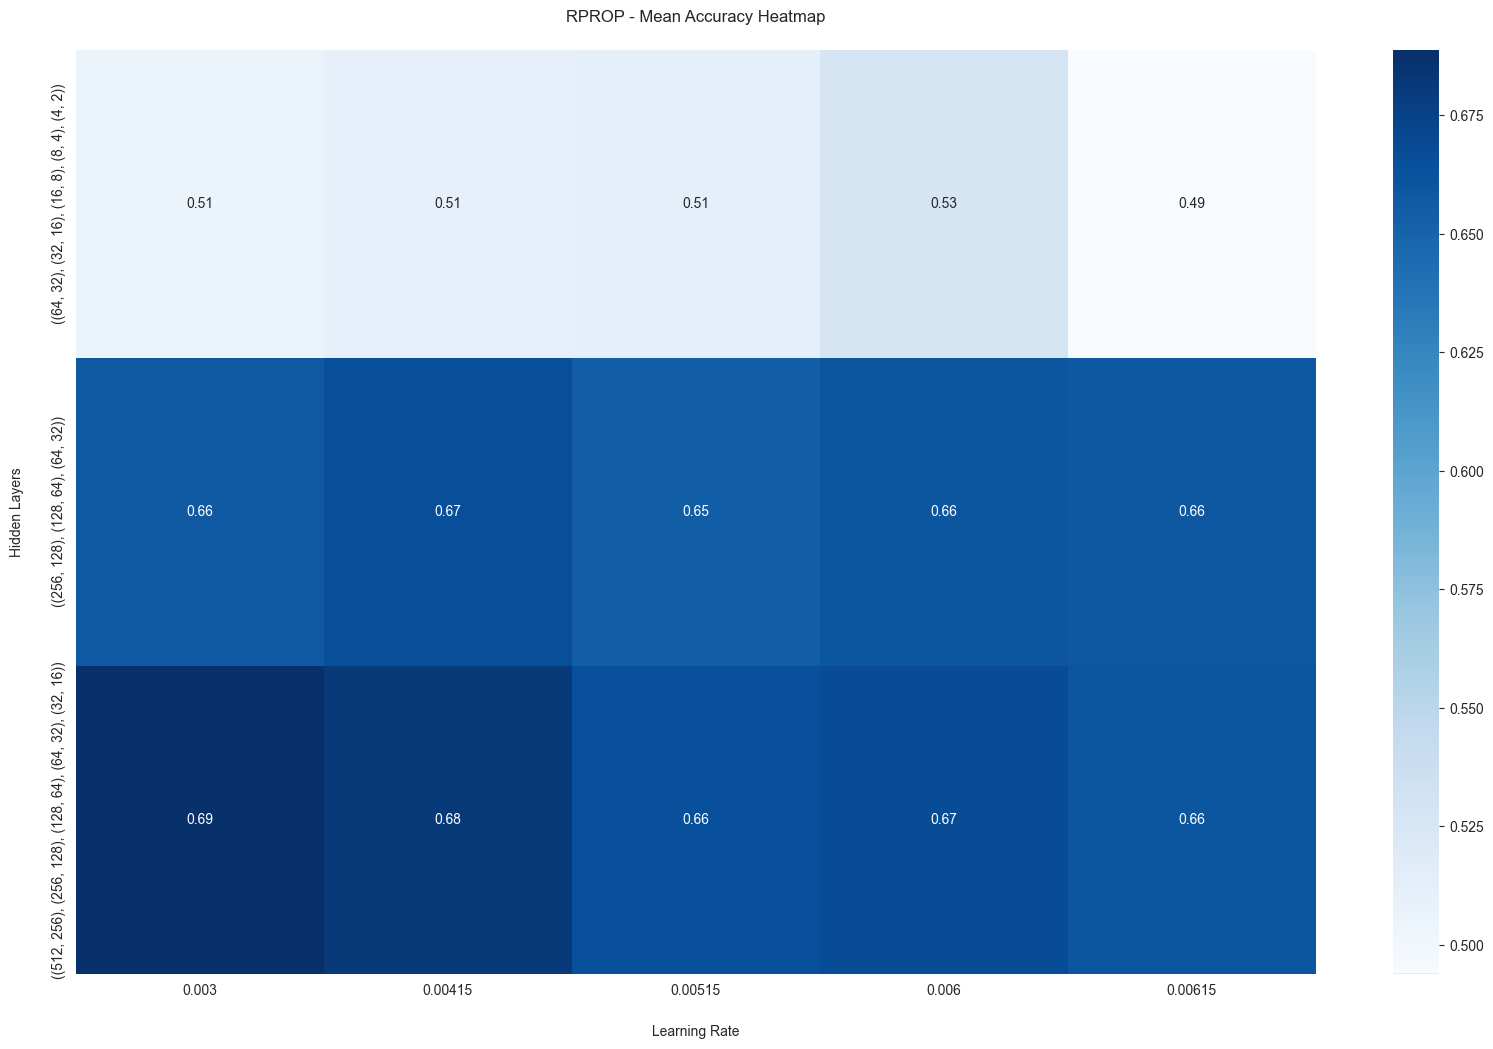

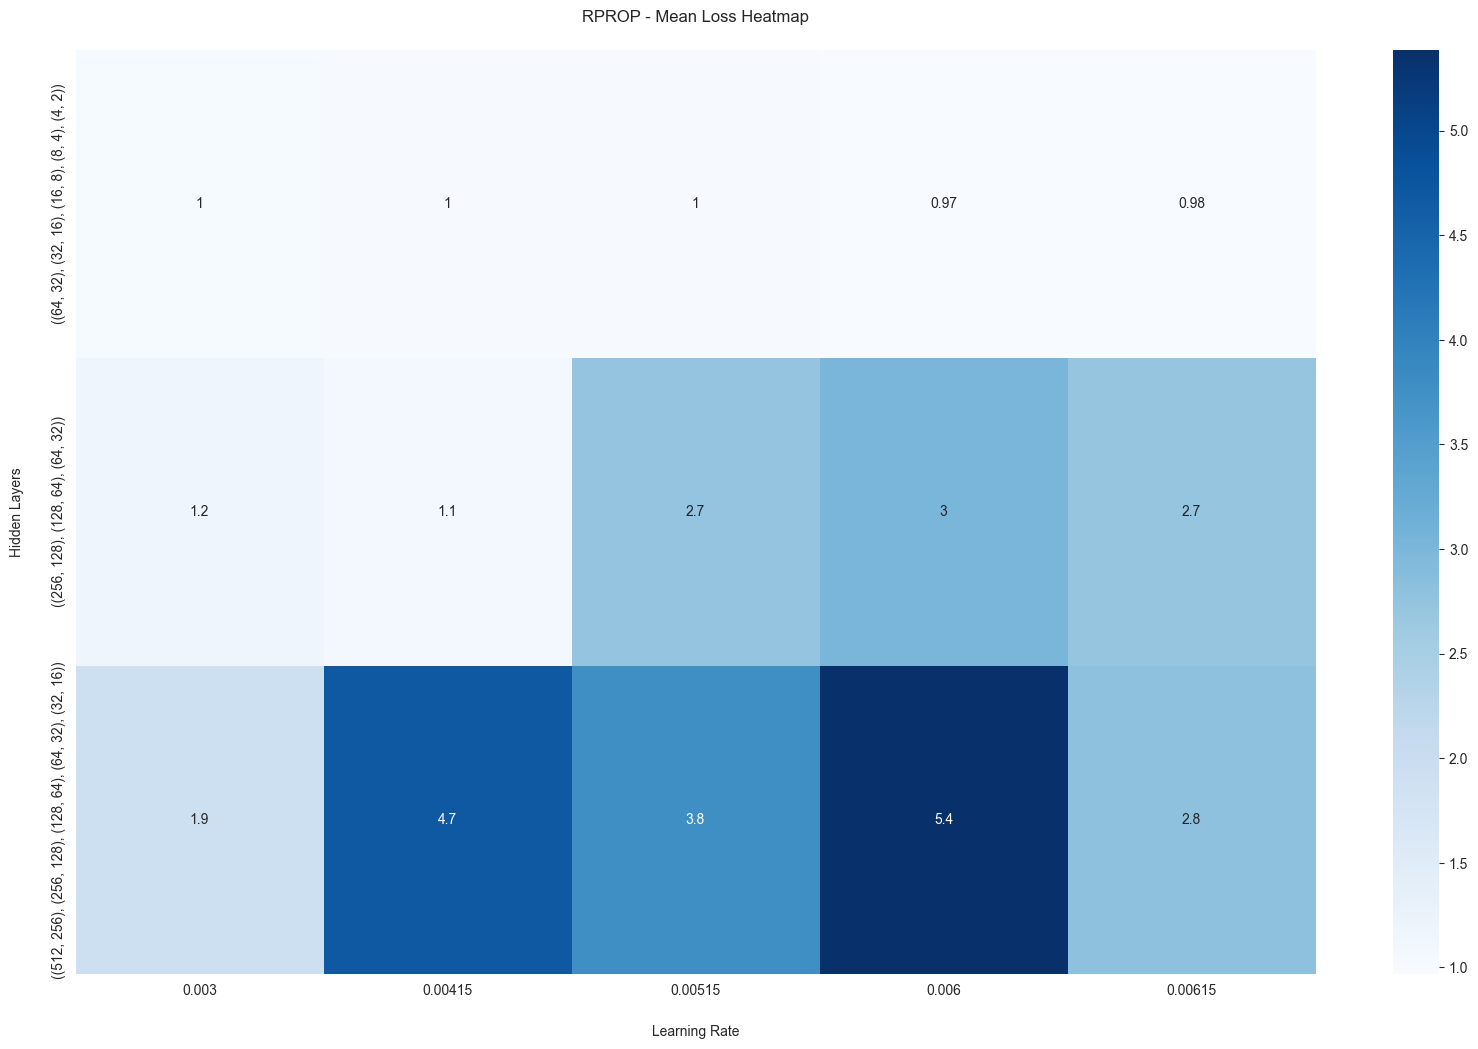

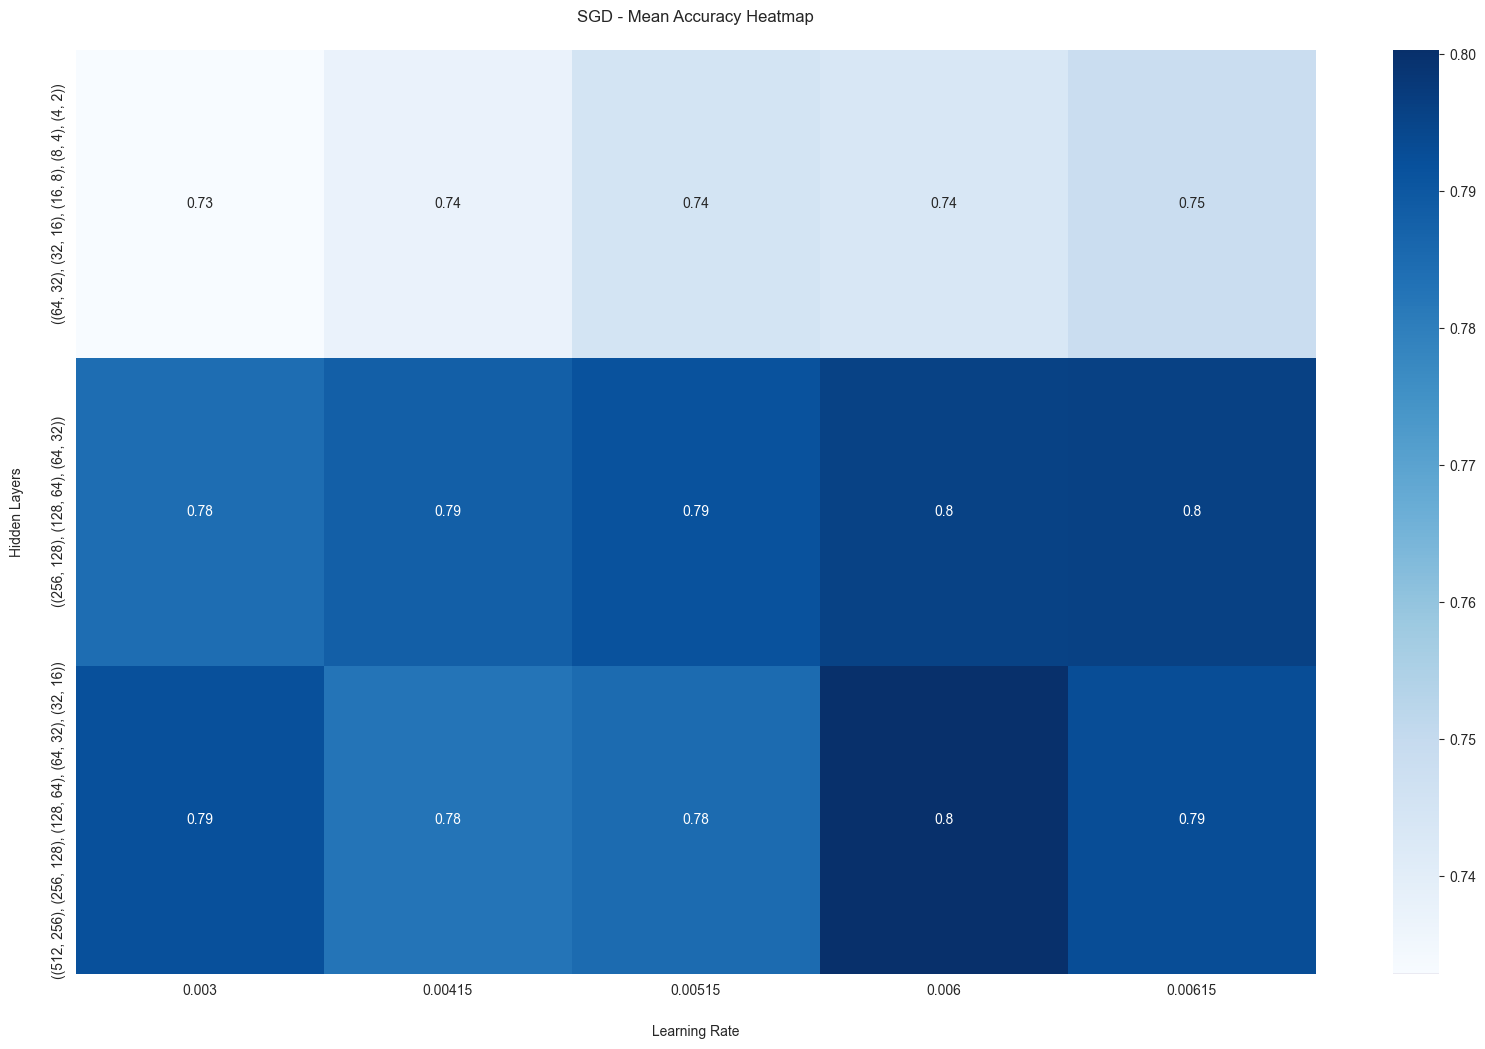

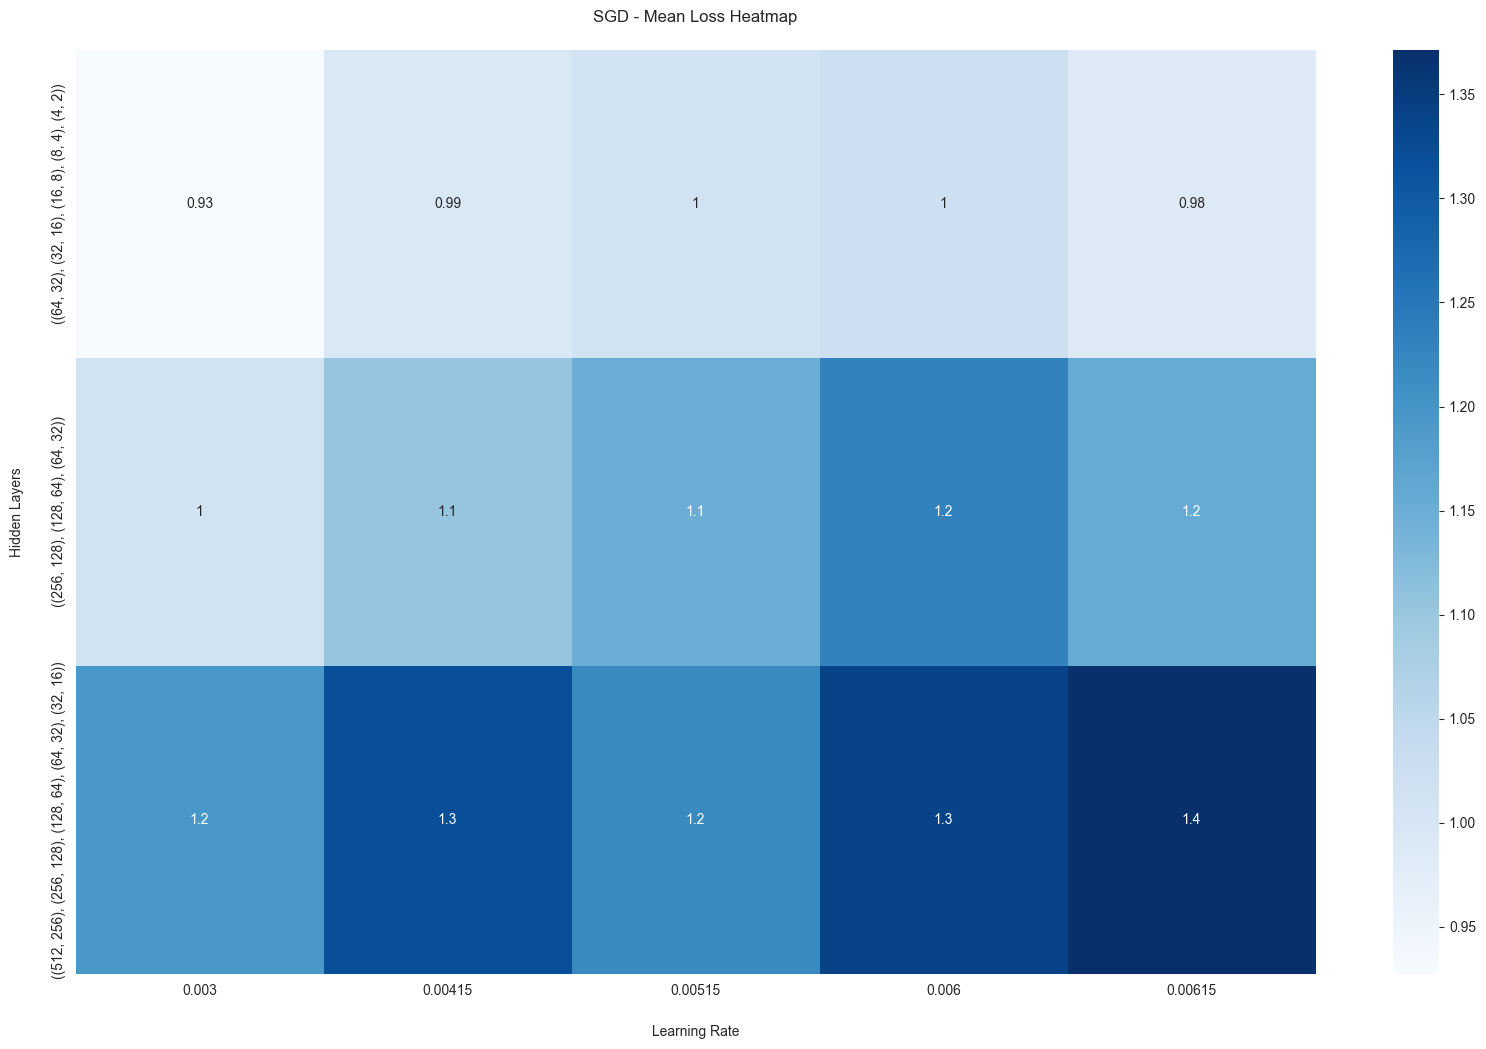

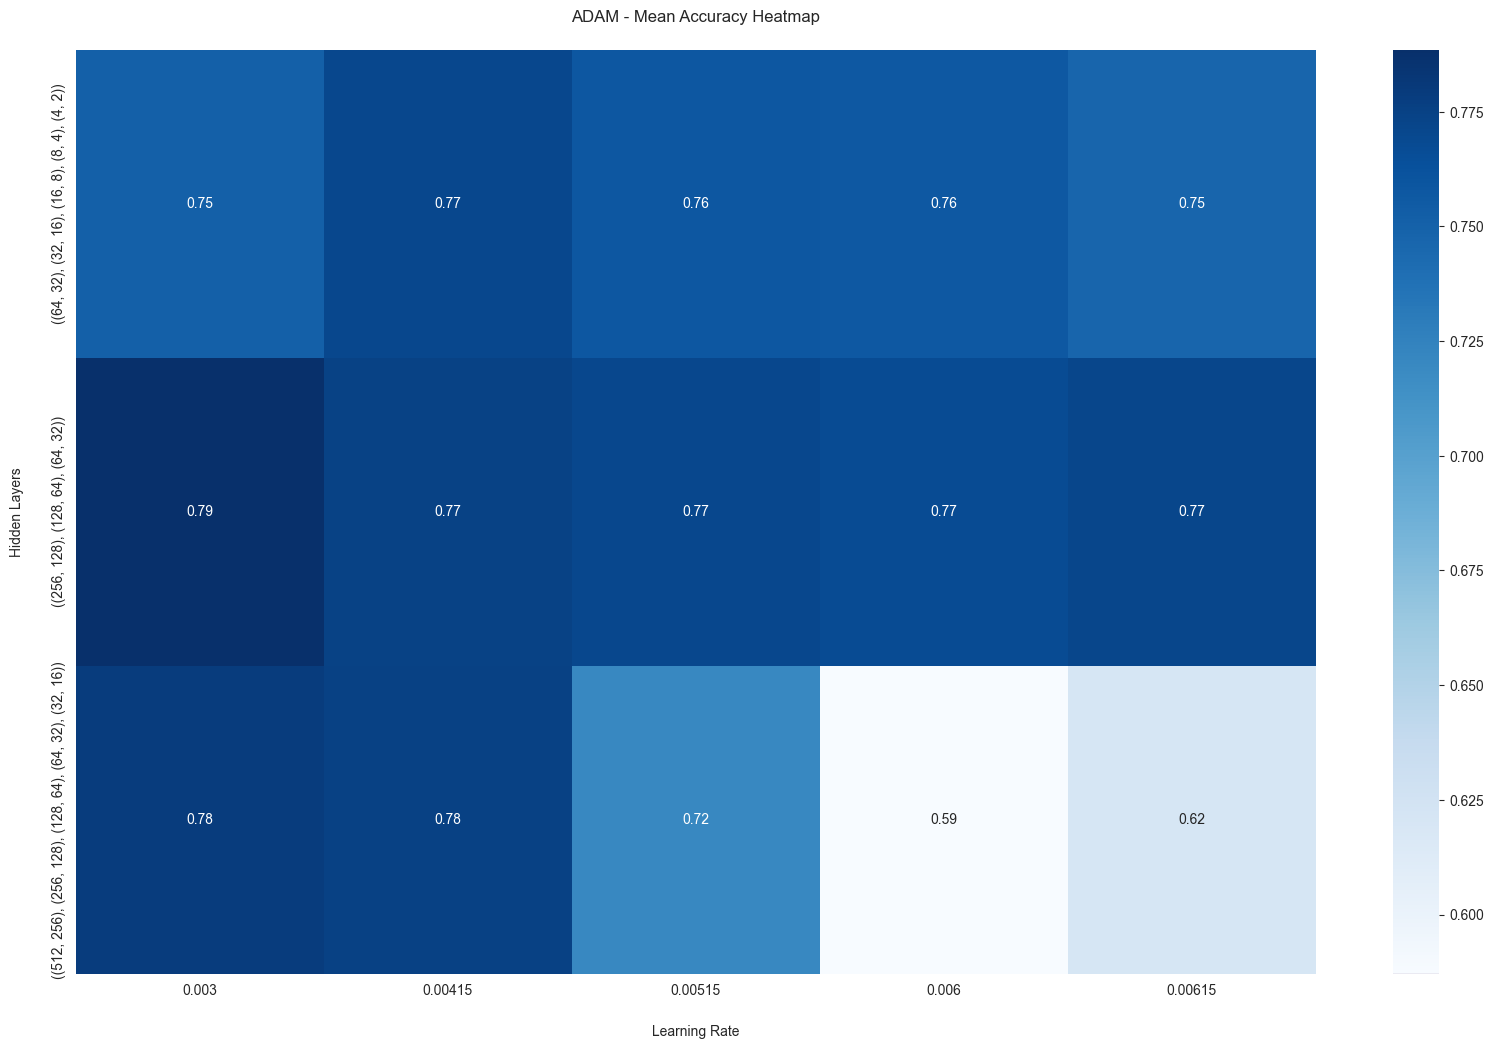

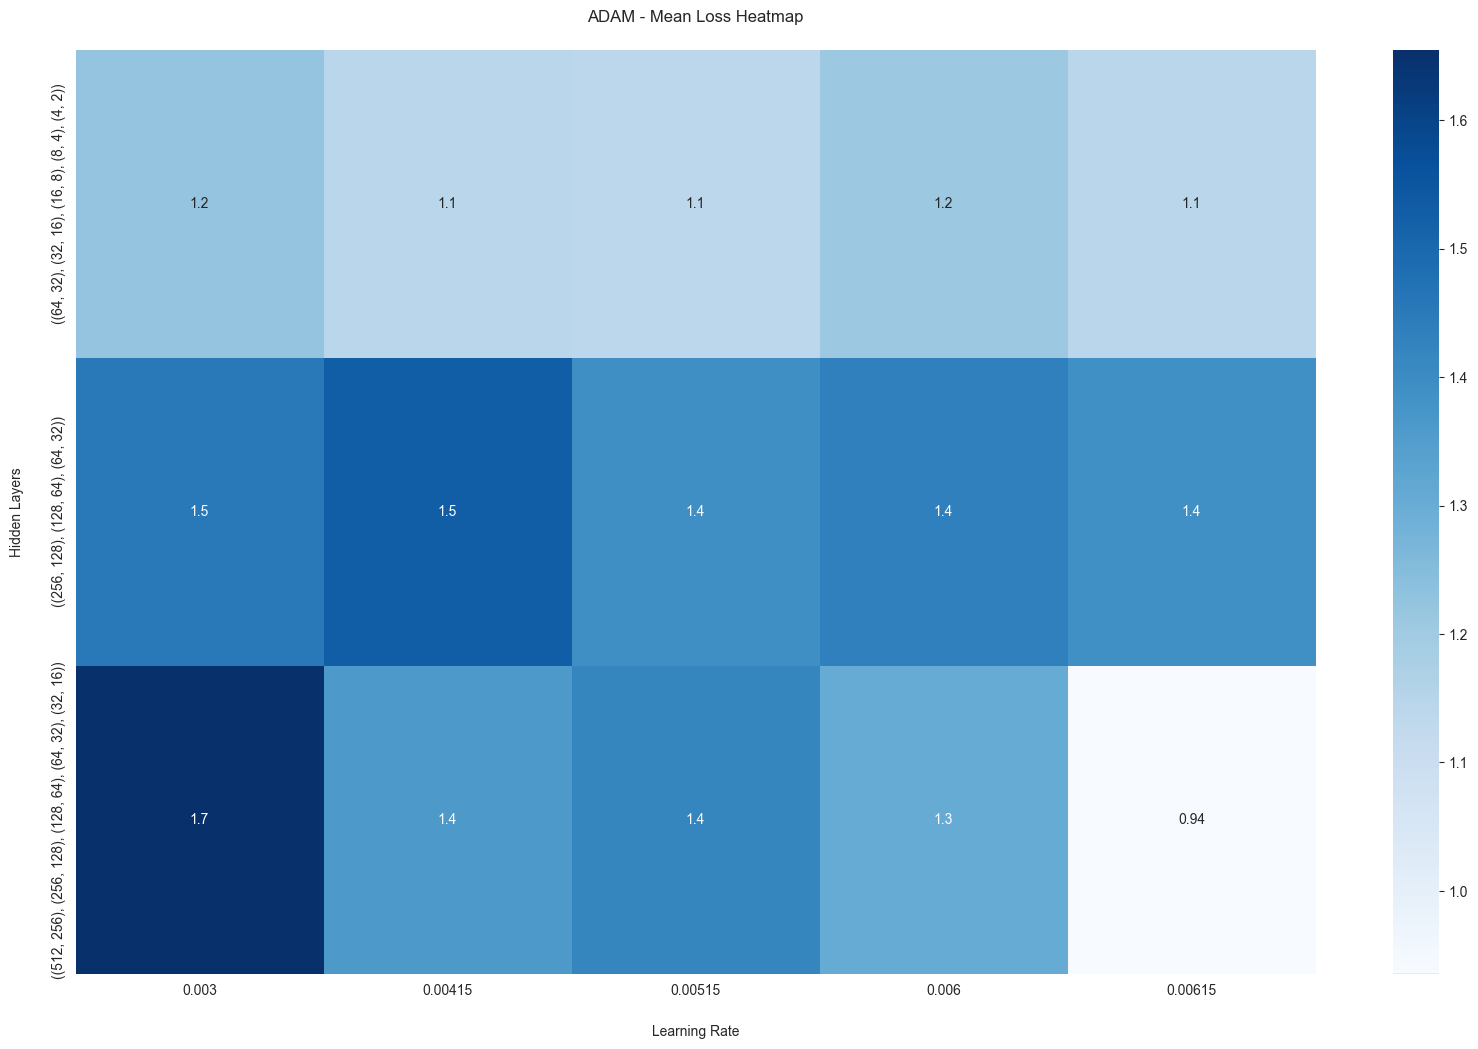

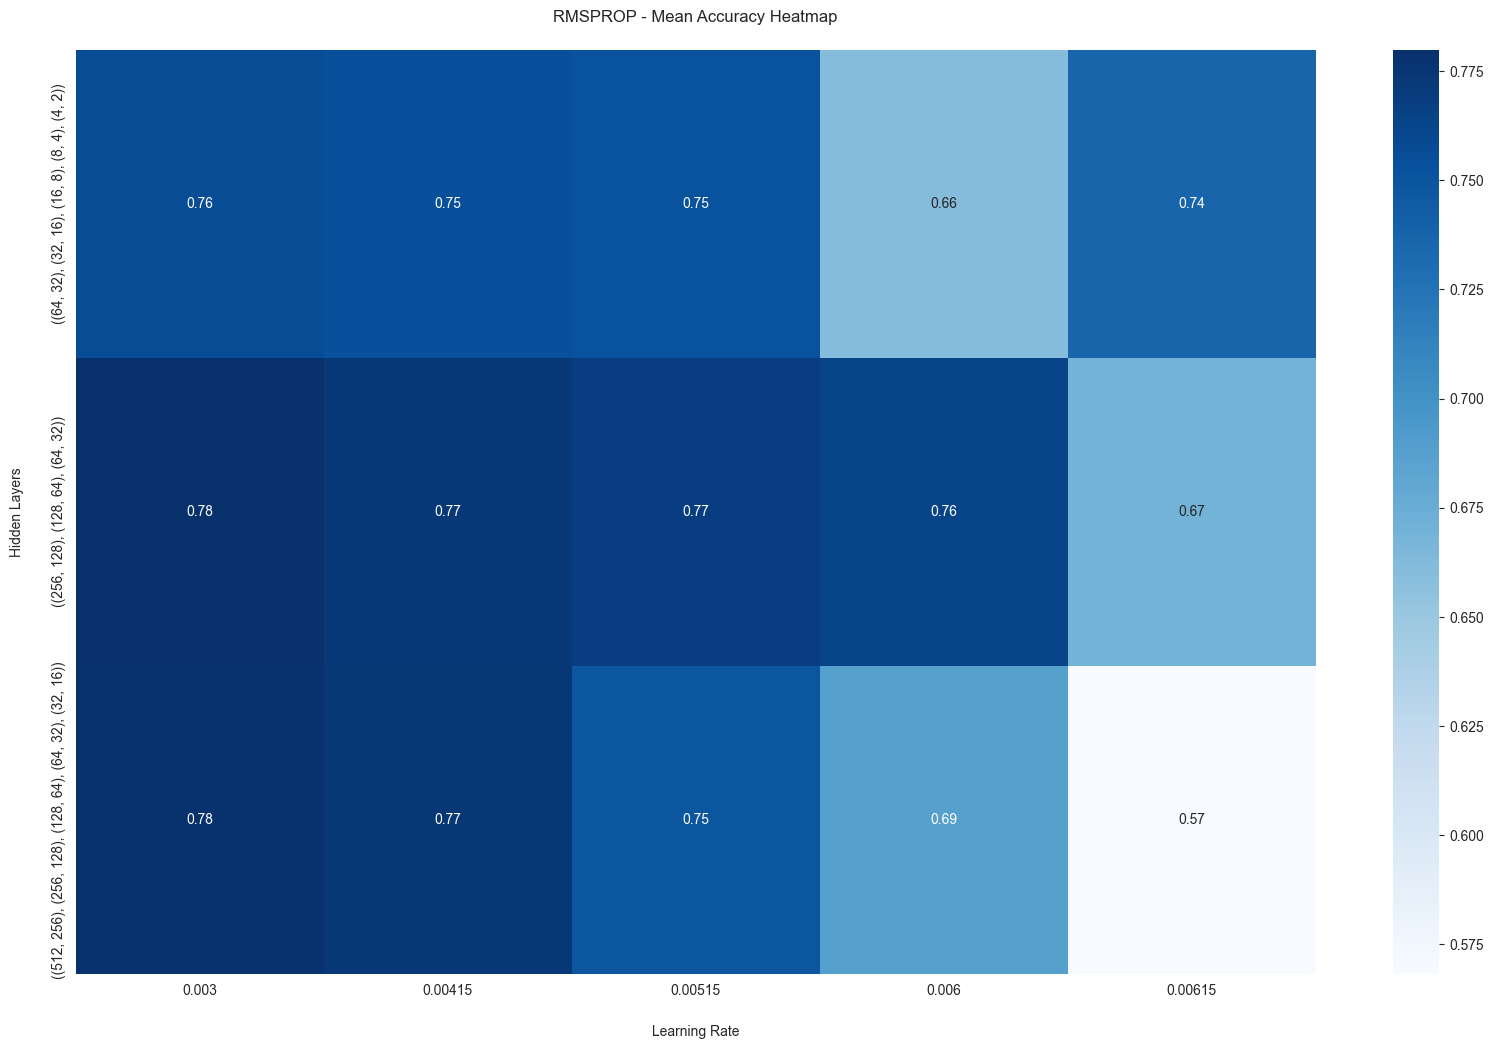

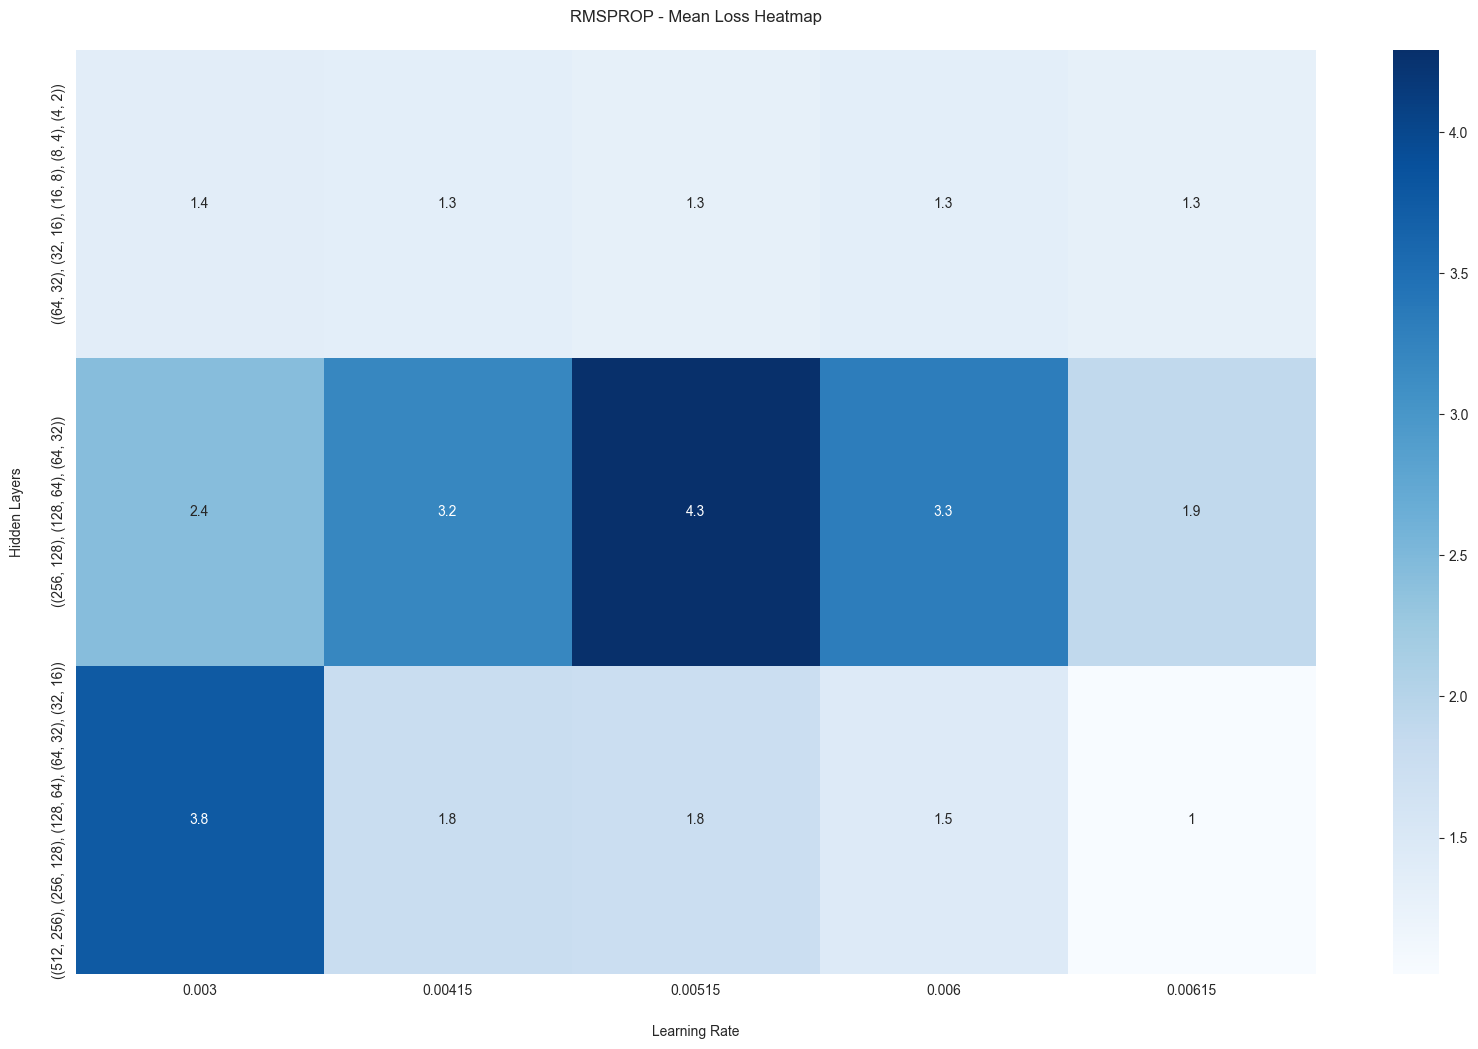

In [515]:
optimizer_names = ['rprop', 'sgd', 'adam', 'rmsprop']

for optimizer_name in optimizer_names:
    print('===' * 3 + f'PERFORMING GRID SEARCH FOR OPTIMIZER {optimizer_name.upper()}' + '===' * 3)

    grid_search(
        seed=999,
        num_of_splits=5,
        param_grid={
            'learning_rate': [0.003, 0.00415, 0.00515, 0.006, 0.00615],
            'hidden_layers': [
                [(512, 256), (256, 128), (128, 64), (64, 32), (32, 16)],
                [(256, 128), (128, 64), (64, 32)],
                [(64, 32), (32, 16), (16, 8), (8, 4), (4, 2)]
            ],
        },
        num_of_epoches=250,
        optimizer_name=optimizer_name,
        optimizer_momentum=0.5
    )
    print('=' * 60 + '\n')